# Generate Atom-mapped SMILES for RMG reactions.
This notebook helps create atom-mapped SMILES for reactants and products. Two methods are available:

1. Atommapping according to the templates of RMG reaction families.
2. Atommapping using RXNMapper and in-house H atom mappings.

## Import Modules

In [1]:
import os
import sys
# To add RDMC into PYTHONPATH in case you haven't done
sys.path.append(os.path.dirname(os.path.abspath('')))

from rdmc import Mol, Reaction
from rdmc.mol.helper import parse_xyz_or_smiles_list
from rdtools.atommap import map_h_atoms_in_reaction


# Import RMG dependencies
# You can install RMG according to http://reactionmechanismgenerator.github.io/RMG-Py/users/rmg/installation
# Loading RMG may take a while
try:
    print('Importing RMG modules...')
    print('This step may takes a while...')
    from rdmc.external.rmg import (from_rdkit_mol,
                                   load_rxn_family_database,
                                   generate_reaction_complex,)
    # Load RMG database
    database = load_rxn_family_database(families='all')
except (ImportError, ModuleNotFoundError):
    print('You need to install RMG to use RMG for atommapping!')


# Import RXNMapper
# You can install RXNMapper by `pip install rxnmapper`
try:

    print('Importing RXNMappers modules...')
    from rxnmapper import RXNMapper
except (ImportError, ModuleNotFoundError):
    print('You need to install RXNMapper by pip install rxnmapper')
    \

%load_ext autoreload
%autoreload 2

[23:02:35] WARNING: not removing hydrogen atom without neighbors


Importing RMG modules...
This step may takes a while...
You need to install RMG-Py first!
You need to install RMG to use RMG for atommapping!
Importing RXNMappers modules...


/Users/xiaorui/Apps/mambaforge/envs/xtb_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Examples
You can choose whichever reaction you like, and you are encouraged to provide your own example.

For carbenes and biradicals, you need to specify the multiplicity as well. E.g., `reactants=[('[CH2]', 1)]`

H_migration

In [75]:
reactants = [
    {"smi": "[CH2]CCCCO",},
]
products = [
    {"smi": "[O]CCCCC",}
]

Retroene

In [84]:
reactants = [
    {"smi": "C1=CC(C2C=CCC2)C=C1",},
]
products = [
    {"smi": "C1=CC=CC1",},
    {"smi": "C1=CC=CC1",},
]

H abstraction

In [94]:
reactants = [
    {"smi": "[O]",},
    {"smi": "CCCCO",},
]
products = [
    {"smi": "[OH]",},
    {"smi": "[CH2]CCCO",},
]

1+2_Cycloaddition

In [6]:
reactants = [
    {"smi": "[O]", "mult": 1},
    {"smi": "C=C",},
]
products = [
    {"smi": "C1OC1",},
]

H2_elimination

In [103]:
reactants = [
    {"smi": "CC",},
]
products = [
    {"smi": "[H][H]",},
    {"smi": "C=C",},
]

Bond fission

In [112]:
reactants = [
    {"smi": "CC",},
]
products = [
    {"smi": "[H]",},
    {"smi": "C[CH2]",},
]

1,2_Insertion_carbene

In [8]:
reactants = [
    {"smi": "[CH2]", "mult": 1},
    {"smi": "C=C",},
]
products = [
    {"smi": "CC=C",},
]

# [Method 1] Atommapping using RMG

In [8]:
print("You can neglect the Open Babel Warnings below.")
try:
    # Generate RMG Molecule
    r_mols = parse_xyz_or_smiles_list(reactants)
    p_mols = parse_xyz_or_smiles_list(products)
    reactant_molecules = [from_rdkit_mol(r) for r in r_mols]
    product_molecules = [from_rdkit_mol(p) for p in p_mols]

except Exception as e:
    print(e)
    print('Have issues generating molecules.')
else:
    # A product complex with the same atom indexing as the reactant is generated
    reactant_complex, product_complex = generate_reaction_complex(
                                            database,
                                            reactant_molecules,
                                            product_molecules,
                                            verbose=True)

if reactant_complex:
    r_complex = Mol.FromRMGMol(reactant_complex)
    p_complex = Mol.FromRMGMol(product_complex)

You can neglect the Open Babel Warnings below.


*** Open Babel Warning  in ReadMolecule
  Problems reading an XYZ file: The first line must contain the number of atoms.
*** Open Babel Warning  in ReadMolecule
  Problems reading an XYZ file: The first line must contain the number of atoms.
*** Open Babel Warning  in ReadMolecule
  Problems reading an XYZ file: The first line must contain the number of atoms.


C=C + [CH2] <=> C=CC
RMG family: 1,2_Insertion_carbene
Is forward reaction: True


### Generate Reaction SMILES

Visualize reactant and product in molecule graphs

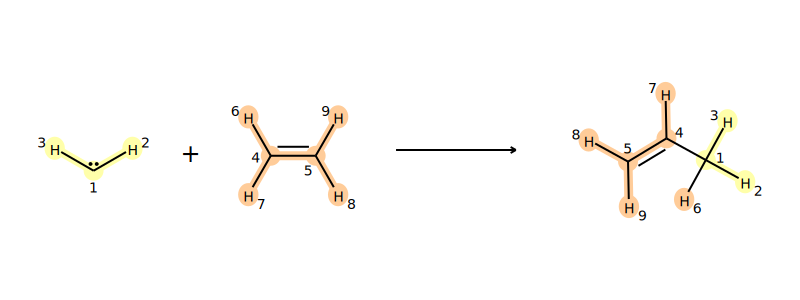

[C:1]([H:2])[H:3].[C:4](=[C:5]([H:8])[H:9])([H:6])[H:7]>>[C:1]([H:2])([H:3])([C:4](=[C:5]([H:8])[H:9])[H:7])[H:6]


In [9]:
rxn = Reaction(r_complex, p_complex)
display(rxn)
print(rxn.to_smiles())

# [Method 2] Atommapping using RXNMapper (Beta)

### Map heavy atoms using RXNMapper

Based on version 90a7012c9c0127f4a347baf815e270d8807b5a39

[Developer TODO]

- A deeper investigation in rxn_mapper is need in the future to check possibilities of built-in H mapping 

In [187]:
rxn_mapper = RXNMapper()
r_complex_smi = ".".join([r["smi"] for r in reactants])
p_complex_smi = ".".join([p["smi"] for p in products])
rxns = [r_complex_smi + '>>' + p_complex_smi,]
atommapped_rxn_smi = rxn_mapper.get_attention_guided_atom_maps(rxns)[0]['mapped_rxn']
atommapped_rxn_smi

'[CH:1]1=[CH:2][CH2:3][CH:4]2[CH:5]1[CH:10]1[CH:6]=[CH:7][CH:8]2[CH2:9]1>>[CH:1]1=[CH:2][CH2:3][CH:4]=[CH:5]1.[CH:6]1=[CH:7][CH2:8][CH:9]=[CH:10]1'

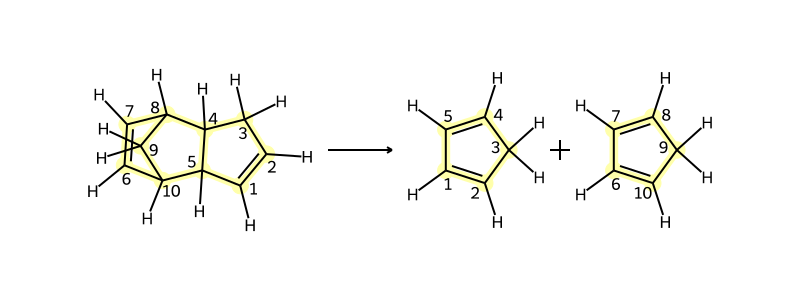

In [193]:
rxn = Reaction.from_reaction_smiles(atommapped_rxn_smi)
display(rxn)
r_complex = rxn.reactant_complex
p_complex = rxn.product_complex

### Map H atoms

In [194]:
r_complex, p_complex = map_h_atoms_in_reaction(r_complex, p_complex)

### Generate Reaction Smiles

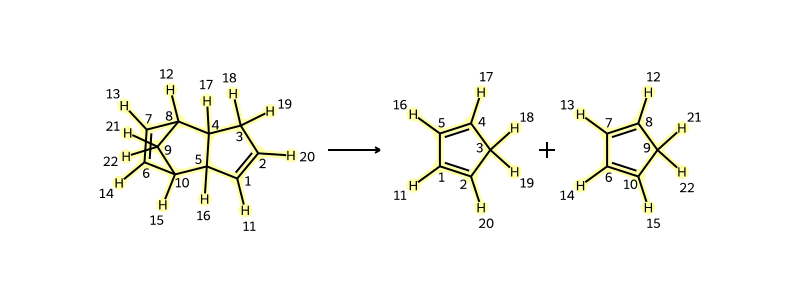

[C:1]1([H:11])=[C:2]([H:20])[C:3]([H:18])([H:19])[C:4]2([H:17])[C:5]1([H:16])[C:10]1([H:15])[C:6]([H:14])=[C:7]([H:13])[C:8]2([H:12])[C:9]1([H:21])[H:22]>>[C:1]1([H:11])=[C:2]([H:20])[C:3]([H:18])([H:19])[C:4]([H:17])=[C:5]1[H:16].[C:6]1([H:14])=[C:10]([H:15])[C:9]([H:21])([H:22])[C:8]([H:12])=[C:7]1[H:13]


In [195]:
new_rxn = Reaction(r_complex, p_complex)
display(new_rxn)
print(new_rxn.to_smiles())